In [1]:
import numpy as np
from numpy import pi,e,sqrt,log,cos,sin
from matplotlib import pyplot as plt
import sympy as sym
import atom
import mot



def v_mat_sym(vecs):
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  v *outer* v /norm(v)
    """
    return sum([np.outer(v,v)/sym.sqrt(np.dot(v,v)) for v in vecs])
def b_mat_sym(vecs,pols):
    """
    generate the matrix transform due to a series of vectors
    mat = sum:  v *outer* v /norm(v)
    """
    return sum([s*np.outer(v,v)/sym.sqrt(np.dot(v,v)) for (v,s) in zip(vecs,pols)])
    
    


In [ ]:
from scipy.special import ellipk as K
from scipy.special import ellipe as E
mu0=1.25663706212e-6#N/A^2
def loop_primitive(r,z_d,diam=1,I=1):
    """
    Tests
    B(0,0) for 1A, 1m diameter: 0.01256637062 gauss
    B(0,1) for 1A, 1m diameter: 0.00444288294 gauss
    r,z_d are the radial and axial coordinate, given in units of the loop diameter!
    Using analytic formula from: https://tiggerntatie.github.io/emagnet/offaxis/iloopoffaxis.htm
    """
    mu0=1.25663706212e-6#N/A^2
    z=z_d*2 #simplifies the algebra to use radius as dimension
    r=r*2
    B0=1e4*I*mu0/diam ##[gauss] Field strength at center of loop
    
    Q=(1+r)**2 + z**2
    m=4*r/Q
    Bz=B0/(pi*sqrt(Q))*( E(m)*(1-r**2-z**2)/(Q-4*r)+K(m))
    ## Keep track of where r==0 to avoid div by 0
    r_reg=np.copy(r)
    reg_idx=np.where(r==0)
    r_reg[np.where(r==0)]=1
    Br=B0/(pi*sqrt(Q))*(z/r_reg)*( E(m)*(1+r**2+z**2)/(Q-4*r)-K(m))
    ## force B_r=0 on axis
    Br[reg_idx]=0
    return Br,Bz ## Gauss


def loop_tilt(r,z_d,diam=1,I=1,angle=0):
    """
    Tilt the loop by angle [rad] CCW sense
    """
    rotation=np.array([
        [cos(angle),sin(angle)],
        [-sin(angle),cos(angle)]
    ])
    ## Rotate the spatial coordinates
    r_rot,z_rot = np.einsum('ji, mni -> jmn',rotation, np.dstack([r,z_d]))
    ## Evaluate the magnetic field in the rotated coordinates
    Br_rot, Bz_rot = loop_primitive(r_rot,z_rot,diam=diam,I=I)
    ## Undo the rotation on the magnetic field
    Br,Bz = np.einsum('ji, mni -> jmn',np.linalg.inv(rotation), np.dstack([Br_rot,Bz_rot]))
    return Br,Bz

def gradient(Br,Bz,r,z):
    """
    Br,Bz in Gauss
    r,z in meters
    Return [[Brr, Brz],
            [Bzr, Bzz]] 
        in Gauss/meter
        Evaluated at the field minimum
    """
    mag=sqrt(Br**2+Bz**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))

    print(f"Field minimum @ r={r[min_idx]}, z={z[min_idx]}")
    dr,dz=r[0,1]-r[0,0],z[1,0]-z[0,0]
    Grad_Br=np.gradient(Br,dz,dr)
    Grad_Bz=np.gradient(Bz,dz,dr)
    Grad_B=np.array([[Grad_Br[1][min_idx],Grad_Br[0][min_idx]],
                [Grad_Bz[1][min_idx],Grad_Bz[0][min_idx]]]) ## Gauss/meter
    
    return Grad_B

def loop_on_axis(z_d,diam=1,I=1):
    r=diam/2
    z=z_d*diam
    return 1e4*mu0/(4*pi) *(2*pi*r**2*I)/(z**2+r**2)**(3/2)
def loop_test():
    z=np.linspace(-10,10,50)
    
    _,Bz=loop_primitive(np.array([0]),z,diam=1,I=1)
    
    Bz_=loop_on_axis(z,diam=1,I=1)
    err=2*(Bz-Bz_)/(Bz+Bz_)
    print("Testing analytic off axis formula against on-axis formula")
    print(f"Maximum relative error: {np.max(err)}")
    print(f"Mean relative error: {np.mean(err)}")
    if np.max(err) < 10**10:
        print("TEST PASSED")
        
loop_test()

In [11]:
loop=mot.magneticCoil(diameter=0.1,turns=50,current=10,origin=[0,0,-0.05])
loop2=loop.copy()
loop2.shift([0,0,+0.1])
loop2.current=-loop2.current
dummy_coils=mot.coilSystem([loop,loop2])
dummy_coils.setROI( (-0.07,0.07,100j),(-0.07,0.07,100j) )

Cs=atom.cesium()

**** tetrahedral MOT *****



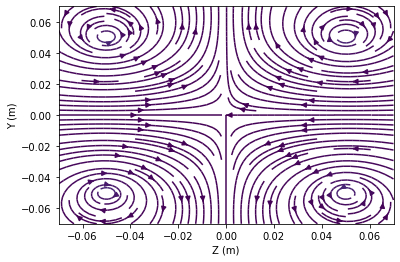

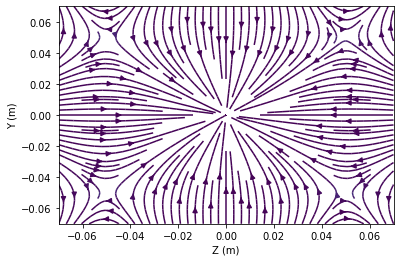

Number of lasers: 4

Radiation balance: [-1.61e-15 -2.42e-15  2.01e-15] Isat

Net acceleration: [-2.47e-12 -3.71e-12  3.09e-12] m/s^2 
Effective offset field: [3.22e-13 4.82e-13 8.04e-13] Gauss

doppler structure matrix: 
[[ 1.21e+01 -3.55e-15 -3.11e-15]
 [-3.55e-15  1.21e+01 -1.55e-15]
 [-3.11e-15 -1.55e-15  1.21e+01]]

doppler force: [[ 2.70e+02 -7.93e-14 -6.94e-14]
 [-7.93e-14  2.70e+02 -3.47e-14]
 [-6.94e-14 -3.47e-14  2.70e+02]] 
 m/s^2 per m/s
magnetic structure matrix: 
[[ 1.21e+01 -3.55e-15 -3.11e-15]
 [-3.55e-15  1.21e+01 -1.55e-15]
 [-3.11e-15 -1.55e-15 -6.05e+00]]

magnetic force:
 [[ 7.69e+00 -2.26e-15 -1.98e-15]
 [-2.26e-15  7.69e+00 -9.88e-16]
 [-1.98e-15 -9.88e-16 -3.85e+00]]  m/s^2 per gauss


In [13]:
"""
Pure tetrahedron

unpolarized matrix:
All 3 eigenvalues are exactly 4/3
no preferred eigenvectors

polarized matrix:
xy-plane eigenvalues are -2x z-axis eigenvalue
"""

incoming_laser=mot.laser(intensity=10,polarization=-1,direction=[0,0,-1])

# Tetrahedral vertex-center-vertex angle
theta=pi-np.arccos(-1/3)

## 1st mirror is in YZ plane
reflected1=incoming_laser.reflect(1,[0,sin(theta/2),cos(theta/2)])

## 2nd and 3rd mirrors are 1/3 rotation in the XY plane
reflected3=incoming_laser.reflect(1,[-sin(4*pi/3)*sin(theta/2),cos(4*pi/3)*sin(theta/2),cos(theta/2)])
reflected2=incoming_laser.reflect(1,[-sin(2*pi/3)*sin(theta/2),cos(2*pi/3)*sin(theta/2),cos(theta/2)])

lasers=[incoming_laser, reflected1,reflected2,reflected3]


tetraMOT=mot.mot(dummy_coils,lasers,Cs.D2,detuning=10)

print("**** tetrahedral MOT *****\n")


dummy_coils.view()
tetraMOT.view()
tetraMOT.printProperties()

(50, 50, 49)
Field minimum @ x=0.001,y=0.001, z=-0.001
B=1.15 Gauss 
[[ 6.66349222e+00 -4.16478316e-04 -1.65876786e-03]
 [-4.16478316e-04  6.66349222e+00 -1.65876786e-03]
 [-1.67305088e-03 -1.67305088e-03 -1.33308703e+01]]


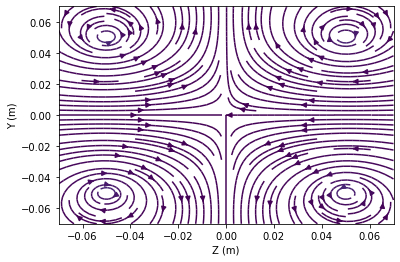

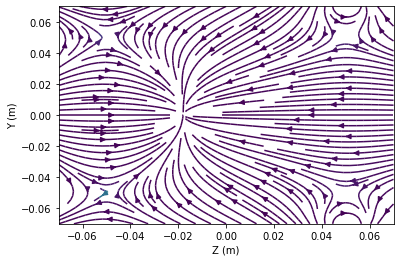

Number of lasers: 6

Radiation balance: [ 0.    0.   -0.11] Isat

Net acceleration: [   0.      0.   -440.88] m/s^2 
Effective offset field: [ -0.    -0.   -24.43] Gauss

doppler structure matrix: 
[[4.54 0.   0.  ]
 [0.   4.54 0.  ]
 [0.   0.   4.42]]

doppler force: [[649.64   0.     0.  ]
 [  0.   649.64   0.  ]
 [  0.     0.   633.4 ]] 
 m/s^2 per m/s
magnetic structure matrix: 
[[ 4.54  0.    0.  ]
 [ 0.    4.54  0.  ]
 [ 0.    0.   -4.42]]

magnetic force:
 [[ 18.51   0.     0.  ]
 [  0.    18.51   0.  ]
 [  0.     0.   -18.04]]  m/s^2 per gauss


In [12]:
"""
Cubic MOT config
"""
## 3 pairs of mutually orthogonal beams
z0=mot.laser(intensity=2.5,polarization=-1,direction=[0,0,-1])
## Additional HWP (usually a QWP double pass) is necessary
z1=z0.reflect(0.95,[0,0,1])
z1.polarization=-1*z1.polarization
x0=mot.laser(intensity=2.5,polarization=1,direction=[-1,0,0])
x1=x0.reflect(1,[1,0,0])
x1.polarization=-1*x1.polarization
y0=mot.laser(intensity=2.5,polarization=1,direction=[0,-1,0])
y1=y0.reflect(1,[0,1,0])
y1.polarization=-1*y1.polarization
lasers=[z0,z1,x0,x1,y0,y1]

cubicMOT=mot.mot(dummy_coils,lasers,Cs.D2,detuning=10)

print(dummy_coils.gradient())
dummy_coils.view()
cubicMOT.view()
cubicMOT.printProperties()

17.852923447860157

In [ ]:
1/cubicMOT.KK**2

In [ ]:
"""
Pure Octahedron
"""

## 4 pairs of beams
## These angles are wrong!

## vertices are easily tabulated in (+-1,+-1,+-1) frame
## Tilt to point one one pair of vertices along the z-axis
#Rot=


l1=mot.laser(intensity=2.5,polarization=-1,direction=[0,0,1])
l2=mot.laser(intensity=2.5,polarization=-1,direction=[0,0,-1])

l3=mot.laser(intensity=2.5,polarization=1,direction=[1,-1,1])
l4=mot.laser(intensity=2.5,polarization=1,direction=[-1,1,-1])

l5=mot.laser(intensity=2.5,polarization=1,direction=[-1,1,1])
l6=mot.laser(intensity=2.5,polarization=1,direction=[1,-1,-1])

l7=mot.laser(intensity=2.5,polarization=1,direction=[-1,-1,1])
l8=mot.laser(intensity=2.5,polarization=1,direction=[1,1,-1])

lasers=[l1,l2,l3,l4,l5,l6,l7,l8]

## Additional HWP (usually a QWP double pass) is necessary

octoMOT=mot.mot(dummy_coils,lasers,Cs.D2,detuning=10)
octoMOT.printProperties()


octoMOT.view()


In [ ]:
"""
Ideal gMOT at 45-deg

2 degenerate eigenvalues in the xy plane
largest eigenvalue along z-axis
"""

## Coil geometry used in gmot test inside old minig chamber
loop=mot.magneticCoil(diameter=2*0.038,turns=48+68,current=6.5,origin=[0,0,-0.074/2])
loop2=loop.copy()
loop2.shift([0,0,0.074])
loop2.current=-2.5

## Create a mot coils system out of the two loops
coils=mot.coilSystem([loop,loop2])
## Create a rectangle about the origin for searching for field zeros
coils.setROI((-0.040,0.040,100j),(-0.040,0.040,100j))
coils.view()

Grad_B=coils.gradient()
print(f"{np.array2string(Grad_B,precision=2)}")
error=coils.symmetry_check(Grad_B)

## Lasers in grating mot based on grating measurements
incoming_laser=mot.laser(intensity=2.5,polarization=-1,direction=[0,0,-1])
diff0,diff1_flat=incoming_laser.diffract(efficiency=[0.05,1/3],bragg_direction=[0,sin(pi/8),cos(pi/8)])
_,diff1_left    =incoming_laser.diffract(efficiency=[0.01,1/3],bragg_direction=[sin(2*pi/3)*sin(pi/8),cos(2*pi/3)*sin(pi/8),cos(pi/8)])
_,diff1_right   =incoming_laser.diffract(efficiency=[0.01,1/3],bragg_direction=[sin(4*pi/3)*sin(pi/8),cos(4*pi/3)*sin(pi/8),cos(pi/8)])
#diff0.polarization=-1*diff0.polarization

lasers=[incoming_laser,diff0,diff1_flat,diff1_left,diff1_right]

gMOT=mot.mot(coils,lasers,Cs.D2,detuning=10)
gMOT.printProperties()
gMOT.view()

In [ ]:
"""
Unbalanced, symmetric gMOT at 45-deg

2 degenerate eigenvalues in the xy plane
largest eigenvalue along z-axis
"""
rot=np.array([
    [sym.cos(2*sym.pi/3),sym.sin(2*sym.pi/3),0],
    [-sym.sin(2*sym.pi/3),sym.cos(2*sym.pi/3),0],
    [0,0,1]
])

q=sym.Symbol("q")
eff=q
v1=np.array([0,0,-1])
v2=eff*sym.sqrt(2)*np.array([1/sym.sqrt(2),0,1/sym.sqrt(2)])
v3=np.matmul(rot,v2)
v4=np.matmul(rot,v3)
vs=[v1,v2,v3,v4]
print(vs)
print("")
pols=[1,-1,-1,-1]
mat=v_mat_sym(vs)
print(sym.simplify(mat))
print("")
pol_mat = b_mat_sym(vs,pols)
print(sym.simplify(pol_mat))
print("")


b,x,y,z=sym.symbols("b x y z")
B=b*np.array([x,y,-2*z])
print(np.matmul(pol_mat,B))
print("")
tot=sum([sym.sqrt(np.dot(v,v)) for v in vs ] )
print("beta_tot/beta = {}".format(tot))

In [ ]:
def zeq(epsilon):
    mu = 0.006
    b= 10
    delta= 2
    K= 1/(1+16+2.3*(1+sqrt(2) *(1+epsilon)))
    return 1/(8*delta*K) * 1/(mu*b) * epsilon / (2-sqrt(2)*(1+epsilon))
eps = np.linspace(-0.2,0.1,50)
zs=zeq(eps)
plt.plot(eps,zs)
plt.xlabel("epsilon")
plt.ylabel("MOT displacement (cm)")
plt.title("Power imbalance induced MOT displacement")
plt.show()

In [ ]:
zeq(0.1)

In [ ]:
## Anti-helmholtz configuration

## Physical dimensions of Lithium MOT coil setup
## For testing gMOT in old minig chamber
d=0.2 #[m]
n_turns=8*8+1
Itop=30 #[A]
Ibottom=25 #[A]
z_spacing=0.24 #[m]

r,z=np.meshgrid(np.linspace(-0.17,0.17,100),np.linspace(-0.17,0.17,100))
tilt_rad=0*pi/180
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=tilt_rad)


Br_tot,Bz_tot=Br+Br2,Bz+Bz2
mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
#plt.quiver(r,z,Br+Br2,Bz+Bz2)
plt.streamplot(r,z,Br_tot,Bz_tot,density=1.5,color=mag)
plt.show()

In [ ]:
# How does the field zero position depend on a tilt?
n_samples=100
r0,z0=[],[]
I=30
tilts=np.linspace(-30,30,n_samples)
r,z=np.meshgrid(np.linspace(-0.09,0.09,200),np.linspace(-0.09,0.09,200))
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*I,angle=0)
for tilt in tilts:
    tilt_rad=tilt*pi/180
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*I,angle=tilt_rad)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(tilts,r0*100,label="r")
plt.plot(tilts,z0*100,label="z")
plt.xlabel("tilt angle (deg)")
plt.ylabel("field zero displacement (cm)")
plt.title("Shift of zero-crossing with coil tilt")
plt.legend()
plt.show()


In [ ]:
## How does the field zero depend on a current difference?
n_samples=100
r0,z0,b0=[],[],[]
dIs=np.linspace(0,40,n_samples)
r,z=np.meshgrid(np.linspace(-0.05,0.05,100),np.linspace(-0.1,0.1,300))
I=30
for dI in dIs:
    Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*(I-dI/2),angle=0)
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=-n_turns*(I+dI/2),angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
    b0.append(mag[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(dIs,r0*100,label="r")
plt.plot(dIs,z0*100,label="z")
plt.xlabel("current difference (A)")
plt.ylabel("field zero displacement (cm)")
plt.title("~ 1cm/10A shift of zero-crossing, I={}".format(I))
plt.legend()
plt.show()


In [ ]:
## Anti-helmholtz configuration

## Physical dimensions of Lithium MOT coil setup
## For testing gMOT in old minig chamber
d=0.2 #[m]
n_turns=8*8+1
Itop=60 #[A]
Ibottom=20 #[A]
z_spacing=0.25 #[m]

## tetrahedral MOT polz dependent structure matrix
eps=0.1
beta=2.3
beta_tot=(1+sqrt(2)*(1+eps))*beta
Delta_Gamma=2
mu_Gamma=0.006


KK=1/(1+beta_tot+4*Delta_Gamma**2)
C=8*Delta_Gamma*KK**2

Prr,Pzz=beta*(-sqrt(2)/4)*(1+eps),beta*(1-sqrt(2)/2*(1+eps) )
B0=-KK *beta*eps/(C*mu_Gamma*Pzz)

r,z=np.meshgrid(np.linspace(-0.17,0.17,100),np.linspace(-0.17,0.17,100))

## Try a bunch of different currents to tune in the zero crossing
n_samples=100
r0,z0,a0=[],[],[]
Is=np.linspace(50,150,n_samples)
for Itop in Is:
    Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=0)
    Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2+B0
    ar=-C*mu_Gamma*Prr*Br_tot
    az=-C*mu_Gamma*Pzz*Bz_tot
    mag=sqrt(ar**2+az**2)
    
    
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
    a0.append(mag[min_idx])
    #a_tot=a_B+a_net
plt.plot(Is,r0)
plt.plot(Is,z0)
plt.show()


Itop=120
Ibottom=20
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom),angle=0)
Br2,Bz2=loop_tilt(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop),angle=0)
Br_tot,Bz_tot=Br+Br2,Bz+Bz2+B0
ar=-C*mu_Gamma*Prr*Br_tot
az=-C*mu_Gamma*Pzz*Bz_tot
mag=sqrt(ar**2+az**2)
plt.streamplot(r,z,ar,az,density=1.5,color=mag)
plt.show()

In [ ]:
# How does the field zero position depend on a transverse coil shift?
n_samples=100
r0,z0=[],[]
shifts=np.linspace(-0.02,0.02,n_samples)
r,z=np.meshgrid(np.linspace(-0.09,0.09,400),np.linspace(-0.09,0.09,400))
I=40 #[A]
Br,Bz  =loop_tilt(r/d,(z+z_spacing/2)/d,diam=d,I=n_turns*I,angle=0)
for shift in shifts:
    Br2,Bz2=loop_tilt(r/d-shift,(z-z_spacing/2)/d,diam=d,I=-n_turns*I,angle=0)
    
    
    Br_tot,Bz_tot=Br+Br2,Bz+Bz2
    mag=sqrt((Br+Br2)**2+(Bz+Bz2)**2)
    min_idx=np.unravel_index(np.argmin(mag),np.shape(mag))
    r0.append(r[min_idx])
    z0.append(z[min_idx])
r0=np.array(r0)
z0=np.array(z0)
plt.plot(shifts*100,r0*100,label="r")
plt.plot(shifts*100,z0*100,label="z")
plt.xlabel("transverse shift (cm)")
plt.ylabel("field zero displacement (cm)")
plt.title("Shift of zero-crossing with coil tilt")
plt.legend()
plt.show()


In [ ]:
""" Designing a MOT coil geometry 
    Target 5-10 Gauss/cm gradient
    <~3A current
    <5V drop across each coil
"""

n_turns=48
Itop=6.5#[A]
Ibottom=3 #[A]
z_spacing=0.074 #[m]
d=2*0.038 #[m], to cancel 3rd order field variations
print(f"Coil diameter: {d*100:3.3} cm")


rad=d/2

wire_length=pi*d*n_turns
resistivity_14awg = 8.282e-3 ##ohm/meter
d_14awg=1.62 ## [mm]

resistance=wire_length*resistivity_14awg
print(f"wire length: {wire_length:0.2} m \n resistance: {resistance:0.2} Ohm \n Voltage: {Itop*resistance:0.2} V \n Power: {Itop**2*resistance:0.2} W")
print(f"Using 48 turns, make a 6x8 grid. z={8*d_14awg:2.3} mm, r={6*d_14awg:0.2} mm")



r,z=np.meshgrid(np.linspace(-0.027,0.027,401),np.linspace(-0.027,0.027,401))

Br,Bz  =loop_primitive(r/d,(z+z_spacing/2)/d,diam=d,I=-n_turns*(Ibottom))
Br2,Bz2=loop_primitive(r/d,(z-z_spacing/2)/d,diam=d,I=n_turns*(Itop))
Br_tot,Bz_tot=Br+Br2,Bz+Bz2
mag=sqrt(Br_tot**2+Bz_tot**2)

Grad_B = gradient(Br_tot,Bz_tot,r,z)
print(f"Gradient [Gauss/cm]:\n {Grad_B/100}")


plt.streamplot(r,z,Br_tot,Bz_tot,density=1.5,color=mag)
plt.xlim(np.min(r),np.max(r))
plt.ylim(np.min(z),np.max(z))
plt.show()

In [ ]:

op